In [61]:
import os
import glob
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib

In [62]:
%config Completer.use_jedi = False

In [63]:
class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        
        return elapsed_time

# Hyperparameter

In [64]:
# data param
day_len = 30
batch_size = 16

# model param
num_filters = 16

# training param
epochs = 100
learning_rate = 0.001

# Dataset

In [65]:
# load data 
data_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
dmodel = 'IPSL-CM6A-LR' # np.random.choice(np.array(data_models))  # TODO: choose a model

temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(dmodel)).tas)
prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(dmodel)).pr)
npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) # TODO: use all models
npp_ds = np.array(xr.open_mfdataset(np.random.choice(np.array(npp_files))).npp)
npp_ds = np.nan_to_num(npp_ds)
lai_dx = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(dmodel))  # not numpy as time index needed
lai_dx['lai'] = lai_dx.lai.fillna(0)

### Input normalization
##### Axis
- (x) Consider each location as an independent time series: We assume some regions to have overall higher vegetation than others, this information should be kept

- (x) Consider each time slice as an independent image: We assume some seasons to have higher vegetation than others

- (o) Normalize over all axis (time, lat, lon)
##### Range
- Z-standardize inputs, (0,1)-minmax scale outpus (using tanh)

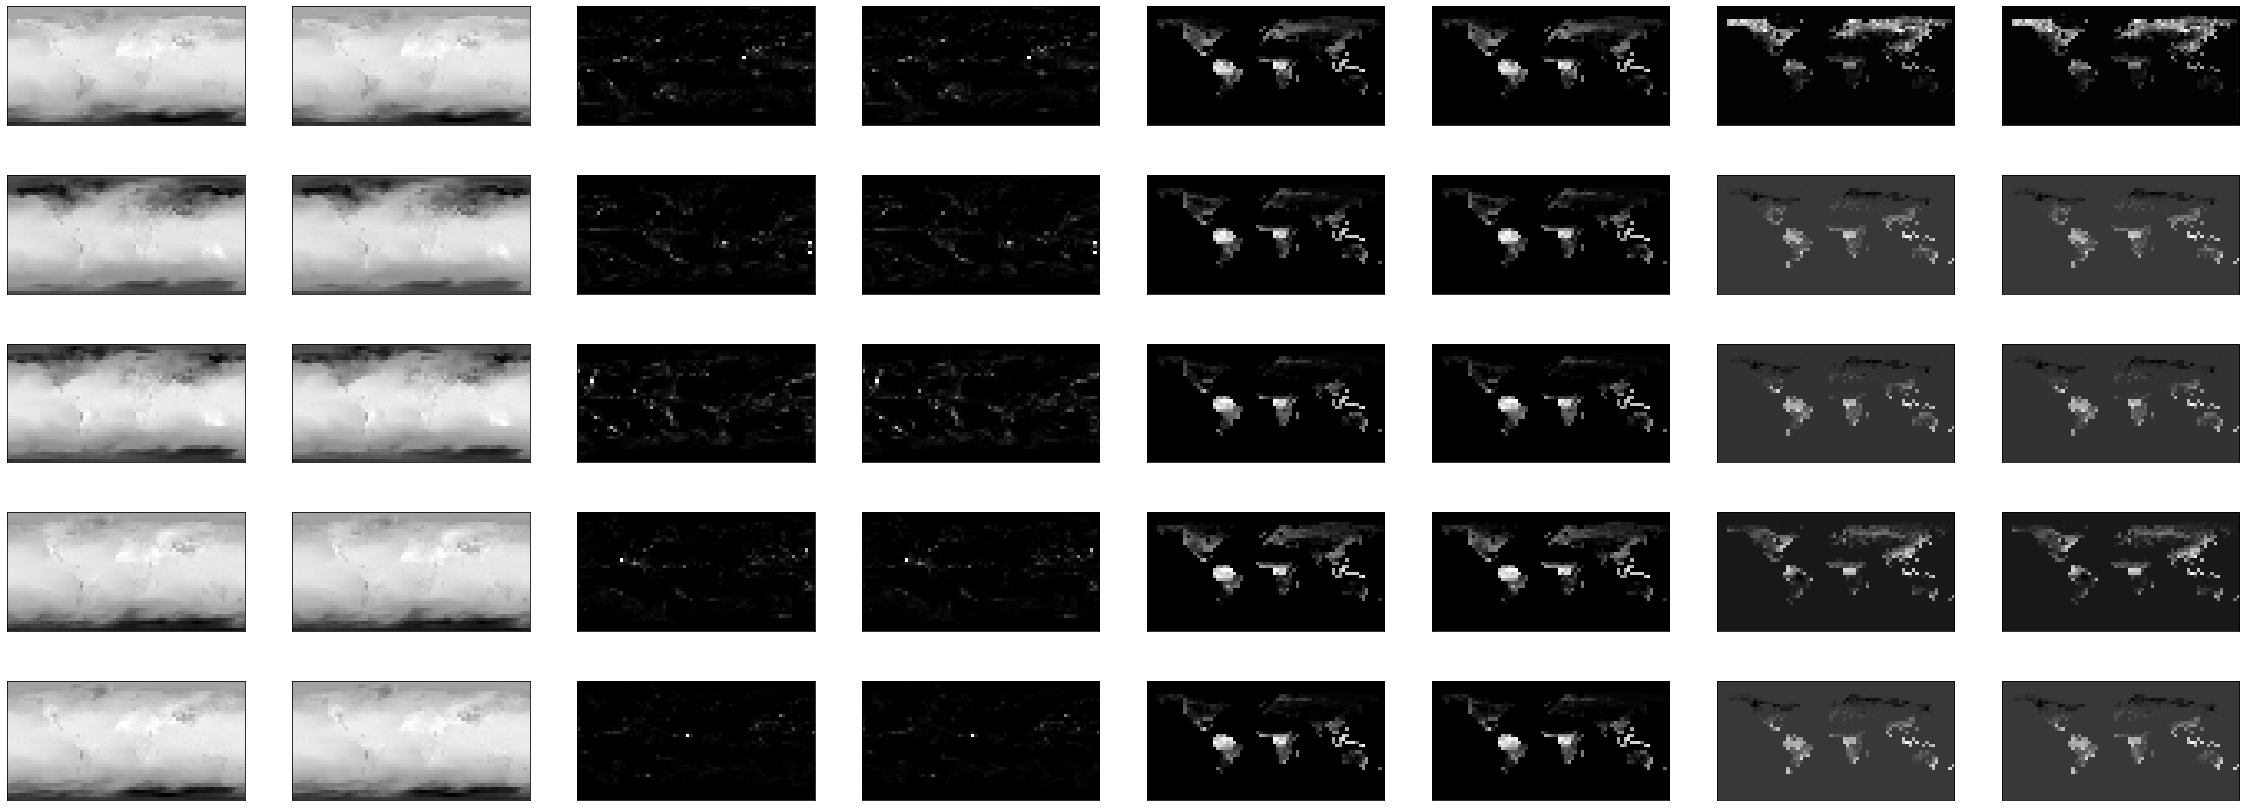

In [98]:


# (0,10) scale outputs
maxi = 10



npp_ds_s = maxi* (npp_ds-np.min(npp_ds))/(np.max(npp_ds)-np.min(npp_ds))
lai_ds_o = lai_dx['lai']  # save unscaled data for plotting purpose
lai_dx["lai"] = maxi * (lai_dx.lai - np.min(lai_dx.lai))/(np.max(lai_dx.lai)-np.min(lai_dx.lai))

# Compare with original image
fig, ax = plt.subplots(nrows = 5, ncols = 8, figsize=(40,15))

# row: 5 random time slices, column: temp,prec,lai,npp with original on left and scaled on right
for i,t in enumerate(np.random.randint(0, max_month, size=5)):
    ax[i,0].imshow(temp_ds[t*30], origin='lower', cmap='gray')
    ax[i,1].imshow(temp_ds_s[t*30], origin='lower', cmap='gray')
    ax[i,2].imshow(prec_ds[t*30], origin='lower', cmap='gray')
    ax[i,3].imshow(prec_ds_s[t*30], origin='lower', cmap='gray')
    ax[i,4].imshow(lai_ds_o[t], origin='lower', cmap='gray')
    ax[i,5].imshow(lai_dx.lai[t], origin='lower', cmap='gray')
    ax[i,6].imshow(npp_ds[t], origin='lower', cmap='gray')
    ax[i,7].imshow(npp_ds_s[t], origin='lower', cmap='gray')

# supress ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

# fig.savefig('figs/normalized_images.png', bbox_inches='tight')

### Generator

In [104]:
train_max_month = 1978-(12*14)
train_min_month = day_len//28

val_max_month = 1978
val_min_month = (day_len//28) + (1978-(12*14))



# min-max scale inputs normalized only on train data (statistics will also be used to normalize test set)

train_max_index = temp_ds.shape[0] - (365*14)

min_temp = np.min(temp_ds[:train_max_index])
max_temp = np.max(temp_ds[:train_max_index])

min_prec = np.min(prec_ds[:train_max_index])
max_prec = np.max(prec_ds[:train_max_index])

min_input= -1
max_input = 1

temp_ds_s = (temp_ds - min_temp) * (max_input - min_input) / (max_temp - min_temp)
                                  
prec_ds_s = (prec_ds - min_prec) * (max_input - min_input) / (max_prec - min_prec)

In [105]:
# range of output month indicies needed for plotting and generator
val_months = 12*14 # 14 years of evaluation data

train_max_month = 1978-val_months
min_month = day_len//28

val_max_month = 1978
val_min_month = train_max_month +1


def train_gen_data_card():
    while True:
        # array to append to
        endstamp = []
        output_day_i = np.zeros(batch_size)
        
        lai = np.zeros((batch_size, npp_ds.shape[1], npp_ds.shape[2]))  # batch, lon, lat
        npp = np.zeros((batch_size, npp_ds.shape[1], npp_ds.shape[2]))
        temp = np.zeros((batch_size, day_len, npp_ds.shape[1], npp_ds.shape[2]))  # batch, time, lon, lat
        prec = np.zeros((batch_size, day_len, npp_ds.shape[1], npp_ds.shape[2]))
        
        # index of output in month
        output_month_i = np.random.randint(train_min_month, train_max_month, size=batch_size)  # y_pred timepoint in int

        # convert output index to timestamp
        try:
            for i in range(batch_size):
                endstamp.append(lai_dx.indexes['time'].to_datetimeindex()[output_month_i[i]])  # cfttimeindex to datetime               
        except:
            for i in range(batch_size):
                endstamp.append(lai_dx.indexes['time'][output_month_i[i]])

        # convert output month index to day index
        for i in range(batch_size):
            output_day_i[i] = (endstamp[i] - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int
        output_day_i = np.int_(output_day_i)

        # save month-based time slices
        lainp = np.array(lai_dx.lai)
        for i in range(batch_size):
            lai[i] = lainp[output_month_i[i]]
        for i in range(batch_size):
            npp[i] = npp_ds_s[output_month_i[i]]

        # day-based metrics
        for i in range(batch_size):
            temp[i] = temp_ds_s[output_day_i[i]-day_len:output_day_i[i]]
        for i in range(batch_size):
            prec[i] = prec_ds_s[output_day_i[i]-day_len:output_day_i[i]]

        # merge features
        inputs = np.stack((temp,prec), axis=-1)  # two features
        outputs = np.stack((lai,npp), axis=-1)

        yield (inputs, outputs)

In [106]:
def val_gen_data_card():
    while True:
        # array to append to
        endstamp = []
        output_day_i = np.zeros(batch_size)
        
        lai = np.zeros((batch_size, npp_ds.shape[1], npp_ds.shape[2]))  # batch, lon, lat
        npp = np.zeros((batch_size, npp_ds.shape[1], npp_ds.shape[2]))
        temp = np.zeros((batch_size, day_len, npp_ds.shape[1], npp_ds.shape[2]))  # batch, time, lon, lat
        prec = np.zeros((batch_size, day_len, npp_ds.shape[1], npp_ds.shape[2]))
        
        # index of output in month
        output_month_i = np.random.randint(val_min_month, val_max_month, size=batch_size)  # y_pred timepoint in int

        # convert output index to timestamp
        try:
            for i in range(batch_size):
                endstamp.append(lai_dx.indexes['time'].to_datetimeindex()[output_month_i[i]])  # cfttimeindex to datetime               
        except:
            for i in range(batch_size):
                endstamp.append(lai_dx.indexes['time'][output_month_i[i]])

        # convert output month index to day index
        for i in range(batch_size):
            output_day_i[i] = (endstamp[i] - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int
        output_day_i = np.int_(output_day_i)

        # save month-based time slices
        lainp = np.array(lai_dx.lai)
        for i in range(batch_size):
            lai[i] = lainp[output_month_i[i]]
        for i in range(batch_size):
            npp[i] = npp_ds_s[output_month_i[i]]

        # day-based metrics
        for i in range(batch_size):
            temp[i] = temp_ds_s[output_day_i[i]-day_len:output_day_i[i]]
        for i in range(batch_size):
            prec[i] = prec_ds_s[output_day_i[i]-day_len:output_day_i[i]]

        # merge features
        inputs = np.stack((temp,prec), axis=-1)  # two features
        outputs = np.stack((lai,npp), axis=-1)

        yield (inputs, outputs)

In [107]:
train_ds = tf.data.Dataset.from_generator(train_gen_data_card, output_types = (tf.float32,tf.float32))
train_ds = train_ds.take(30).prefetch(tf.data.experimental.AUTOTUNE)


val_ds = tf.data.Dataset.from_generator(val_gen_data_card, output_types = (tf.float32,tf.float32))
val_ds = val_ds.take(30).prefetch(tf.data.experimental.AUTOTUNE)

In [108]:
# make sure val and train ds are different
for i in train_ds.take(1):
    print(i[0][0,0,:2,:2])  # (batch, time, lon, lat, features)
for i in val_ds.take(1):
    print(i[0][0,0,:2,:2])

tf.Tensor(
[[[0.7944461  0.        ]
  [0.8078188  0.        ]]

 [[0.7410118  0.00200312]
  [0.67828405 0.00328904]]], shape=(2, 2, 2), dtype=float32)
tf.Tensor(
[[[5.3493476e-01 0.0000000e+00]
  [5.3112578e-01 0.0000000e+00]]

 [[7.2486216e-01 2.8198789e-04]
  [7.2313190e-01 0.0000000e+00]]], shape=(2, 2, 2), dtype=float32)


# Model

In [109]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvLSTM, self).__init__()
        
        self.convlstm2D_1 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same", return_sequences=True,
                                                      activation = "tanh")
        self.bn_1 = tf.keras.layers.BatchNormalization()
        #self.acti_1 = tf.keras.layers.Activation(activation)
        
        self.convlstm2D_2 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same", return_sequences=True,
                                                      activation = "tanh")
        self.bn_2 = tf.keras.layers.BatchNormalization()
        #self.acti_2 = tf.keras.layers.Activation(activation)


        self.convlstm2D_3 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same", return_sequences=True,
                                                      activation = "tanh")
        self.bn_3 = tf.keras.layers.BatchNormalization()
        #self.acti_3 = tf.keras.layers.Activation(activation)
        
        self.convlstm2D_4 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same", return_sequences=True,
                                                      activation = "tanh")
        self.bn_4 = tf.keras.layers.BatchNormalization()
        #self.acti_4 = tf.keras.layers.Activation(activation)
        
        # convolve over time, lat, lon. This means that we assume timesteps close to each other share local similarities
        self.conv3d = tf.keras.layers.Conv3D(filters = 2, kernel_size = (3,3,3), 
                                             activation= "tanh", padding="same")
        # computed convolved sum over all time dimension to get a single time slice
        self.bottleneck = tf.keras.layers.Conv3D(filters=1, kernel_size=1, activation="relu",strides=1)


    def call(self, x, training, input_shape):
        # (batch, time, lat, lon, channel)
        x = tf.ensure_shape(x, input_shape) 
        # (batch, time, lat, lon, channel)
        x = self.convlstm2D_1(x,training= training)
        # (batch, time, lat1, lon1, filter1)
        x = self.bn_1(x,training = training)
        
        x = self.convlstm2D_2(x,training = training)
        x = self.bn_2(x,training = training)
        
        x = self.convlstm2D_3(x,training = training)
        x = self.bn_3(x,training = training)
        
        x = self.convlstm2D_4(x,training = training)
        x = self.bn_4(x, training = training)
        # (batch, time, lat4, lon4, filter4)
        x = self.conv3d(x)
        # (batch, newtime, newlat, newlon, newfilter=2)
        
        x = tf.transpose(x, [0,4,2,3,1])
        # (batch, 2, lat, lon, time)
        x = self.bottleneck(x)
        # (batch, 2, lat, lon, 1)
        
        x = tf.transpose(x, [0,4,2,3,1])
        # (batch, 1, lat, lon, 2)
        x = tf.squeeze(x,axis=1)
        # (batch, lat, lon, 2)
        
        return x

In [115]:
model = ConvLSTM(num_filters=num_filters)
input_shape = (batch_size, day_len, 36, 72, 2)
# model.build(input_shape)
# model.summary() # TODO: doesn't work cuz some layers aren't built?
# TODO: The fact that we can't build the model probably results in undefined rank error

# Training

In [116]:
@tf.function
def train_step(model, data, loss_function, optimizer, train_loss_metric, input_shape=input_shape):
    '''
    Training for one epoch.
    '''
    for img, target in train_ds:
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True, input_shape=input_shape)
            loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
            # TODO: does model have reg loss if we don't use kernel reg?

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        
#@tf.function        
def eval_step(model, ds, loss_function, loss_metric, input_shape=input_shape):
    '''
    Evaluation Loop.
    '''
    for sequence, target in ds:
        # forward pass
        prediction = model(sequence, training=False, input_shape=input_shape)
        # update metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        
    fig, axe = plt.subplots(1,4, figsize=(20,30))
    axe[0].imshow(target[0,:,:,0], cmap='gray', origin='lower')
    axe[1].imshow(prediction[0,:,:,0], cmap='gray', origin='lower')
    axe[2].imshow(target[0,:,:,1], cmap='gray', origin='lower')
    axe[3].imshow(prediction[0,:,:,1], cmap='gray', origin='lower')

# TODO: maybe we want another function (predict) to deploy the model to predict future vegetation and automatically save?

In [117]:
timer = Timer()

# define loss
loss_function = tf.keras.losses.MSE
# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# 2nd-order metric to take mean over all samples
train_loss_metric = tf.keras.metrics.Mean('train_loss')
val_loss_metric = tf.keras.metrics.Mean('val_loss')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_ConvLSTM'    
val_log_dir = 'logs/gradient_tape/' + current_time + '/val_ConvLSTM'       
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

times = []

In [118]:
# training param
epochs = 100
learning_rate = 0.001


[EPOCH] ____________________0____________________
[0] - Finished Epoch in 40.48 seconds - train_loss: 1.0750


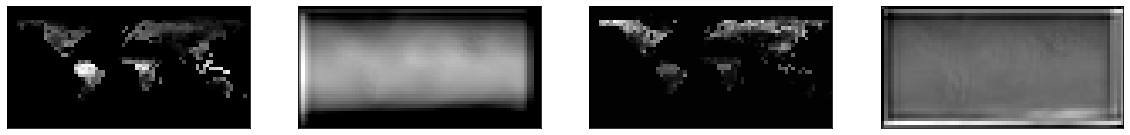


[0] - Finished evaluation - val_loss: 2.6112

[INFO] - Total time elapsed: 0.2066 min. Total time remaining: 20.4573 min.

[EPOCH] ____________________1____________________
[1] - Finished Epoch in 38.36 seconds - train_loss: 0.8403


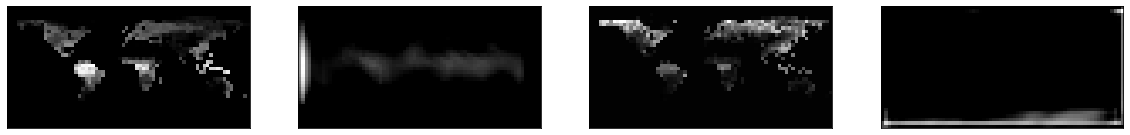


[1] - Finished evaluation - val_loss: 2.7529

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 38.46 seconds - train_loss: 0.7671


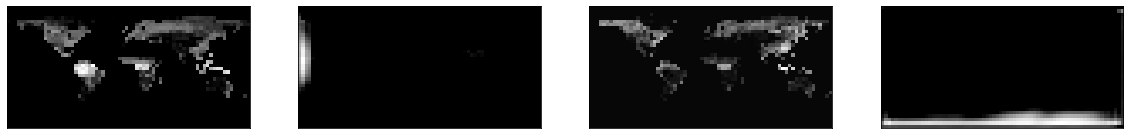


[2] - Finished evaluation - val_loss: 2.7111

[EPOCH] ____________________3____________________
[3] - Finished Epoch in 38.04 seconds - train_loss: 0.6551


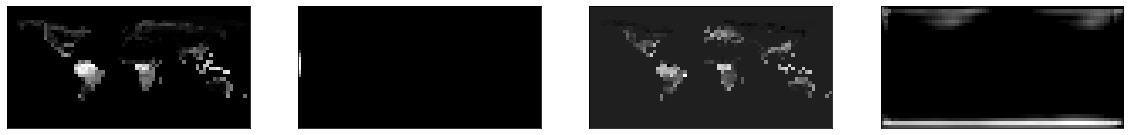


[3] - Finished evaluation - val_loss: 2.7436

[INFO] - Total time elapsed: 0.8389 min. Total time remaining: 20.1337 min.

[EPOCH] ____________________4____________________
[4] - Finished Epoch in 37.68 seconds - train_loss: 0.5947


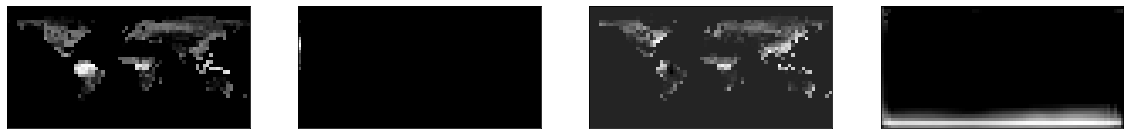


[4] - Finished evaluation - val_loss: 2.6771

[EPOCH] ____________________5____________________
[5] - Finished Epoch in 38.21 seconds - train_loss: 0.5130


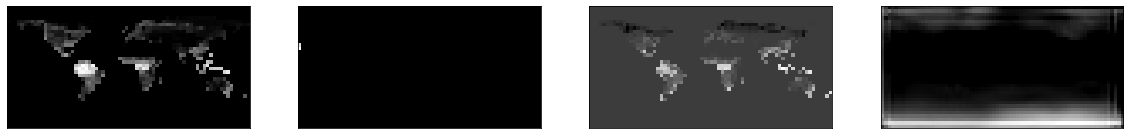


[5] - Finished evaluation - val_loss: 2.5591

[EPOCH] ____________________6____________________
[6] - Finished Epoch in 38.48 seconds - train_loss: 0.4388


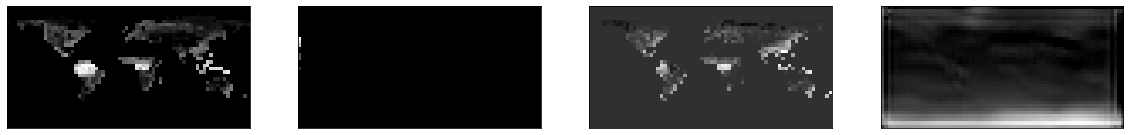


[6] - Finished evaluation - val_loss: 2.2994

[INFO] - Total time elapsed: 1.4639 min. Total time remaining: 19.4486 min.

[EPOCH] ____________________7____________________
[7] - Finished Epoch in 38.71 seconds - train_loss: 0.3800


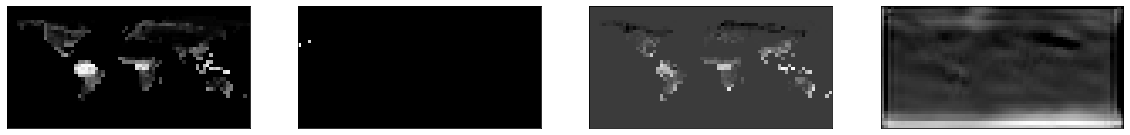


[7] - Finished evaluation - val_loss: 2.2713

[EPOCH] ____________________8____________________
[8] - Finished Epoch in 38.95 seconds - train_loss: 0.3251


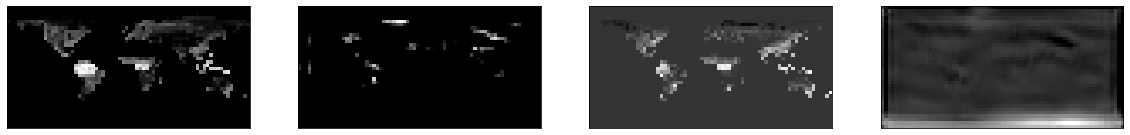


[8] - Finished evaluation - val_loss: 2.1305

[EPOCH] ____________________9____________________
[9] - Finished Epoch in 38.86 seconds - train_loss: 0.2819


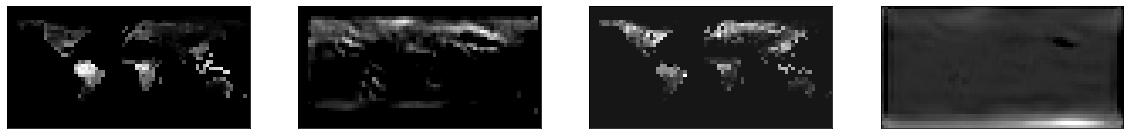


[9] - Finished evaluation - val_loss: 2.0255

[INFO] - Total time elapsed: 2.0983 min. Total time remaining: 18.8845 min.

[EPOCH] ____________________10____________________
[10] - Finished Epoch in 38.76 seconds - train_loss: 0.2314


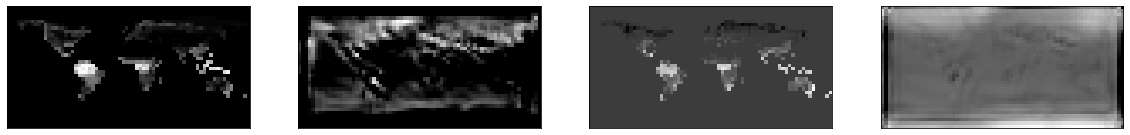


[10] - Finished evaluation - val_loss: 1.9130

[EPOCH] ____________________11____________________
[11] - Finished Epoch in 37.70 seconds - train_loss: 0.2076


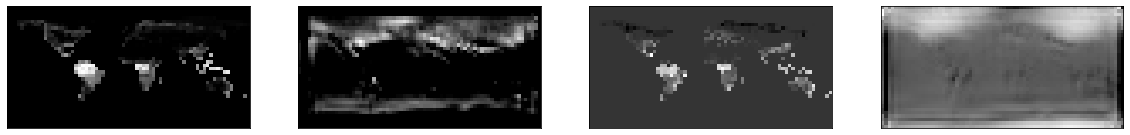


[11] - Finished evaluation - val_loss: 1.8919

[EPOCH] ____________________12____________________
[12] - Finished Epoch in 39.03 seconds - train_loss: 0.1888


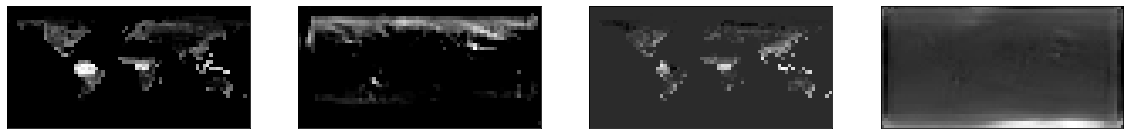


[12] - Finished evaluation - val_loss: 1.7489

[INFO] - Total time elapsed: 2.7286 min. Total time remaining: 18.2608 min.

[EPOCH] ____________________13____________________
[13] - Finished Epoch in 38.67 seconds - train_loss: 0.1661


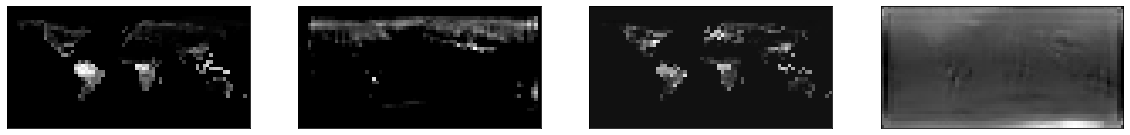


[13] - Finished evaluation - val_loss: 1.7321

[EPOCH] ____________________14____________________
[14] - Finished Epoch in 38.37 seconds - train_loss: 0.1506


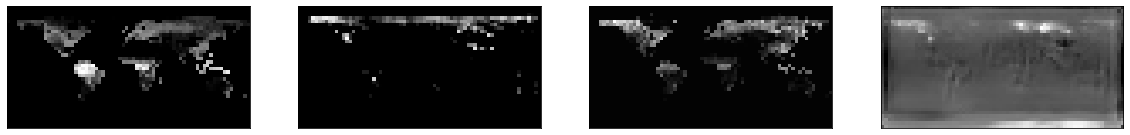


[14] - Finished evaluation - val_loss: 1.6227

[EPOCH] ____________________15____________________
[15] - Finished Epoch in 38.46 seconds - train_loss: 0.1426


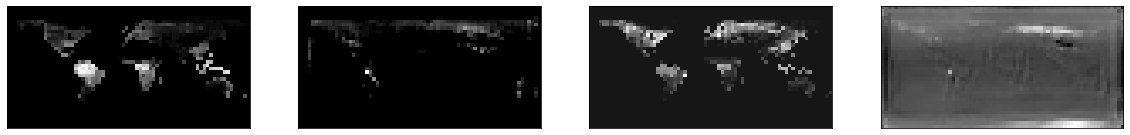


[15] - Finished evaluation - val_loss: 1.4264

[INFO] - Total time elapsed: 3.3557 min. Total time remaining: 17.6173 min.

[EPOCH] ____________________16____________________
[16] - Finished Epoch in 38.39 seconds - train_loss: 0.1356


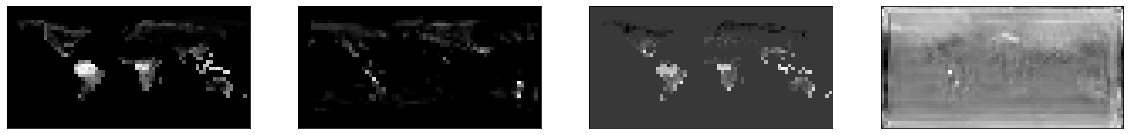


[16] - Finished evaluation - val_loss: 1.2941

[EPOCH] ____________________17____________________
[17] - Finished Epoch in 37.88 seconds - train_loss: 0.1199


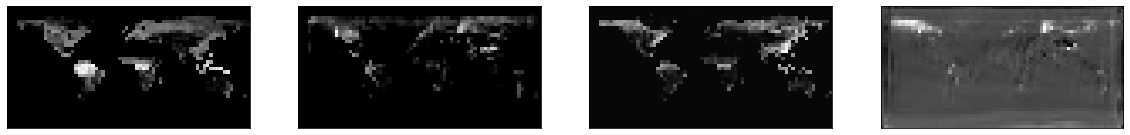


[17] - Finished evaluation - val_loss: 1.1413

[EPOCH] ____________________18____________________
[18] - Finished Epoch in 38.56 seconds - train_loss: 0.1165


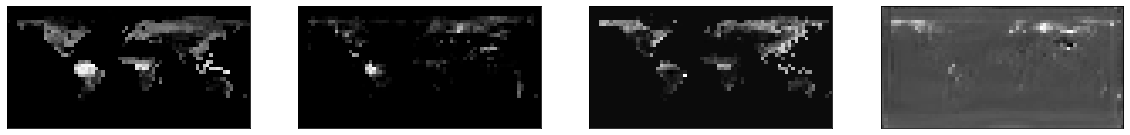


[18] - Finished evaluation - val_loss: 0.9769

[INFO] - Total time elapsed: 3.9856 min. Total time remaining: 16.9913 min.

[EPOCH] ____________________19____________________
[19] - Finished Epoch in 39.28 seconds - train_loss: 0.1108


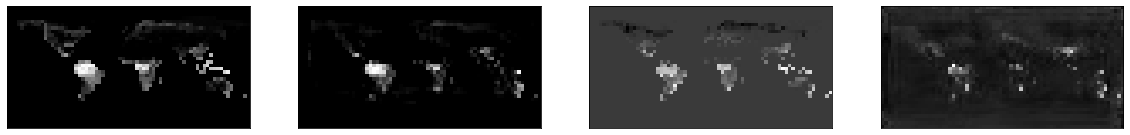


[19] - Finished evaluation - val_loss: 0.5080

[EPOCH] ____________________20____________________
[20] - Finished Epoch in 37.90 seconds - train_loss: 0.1071


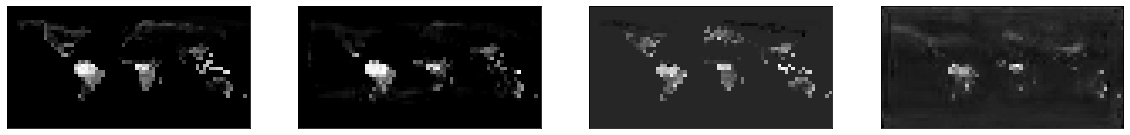


[20] - Finished evaluation - val_loss: 0.3899

[EPOCH] ____________________21____________________
[21] - Finished Epoch in 40.44 seconds - train_loss: 0.0987


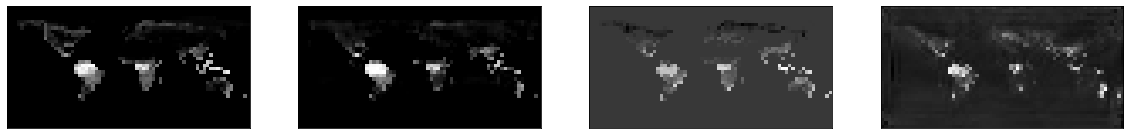


[21] - Finished evaluation - val_loss: 0.2381

[INFO] - Total time elapsed: 4.6181 min. Total time remaining: 16.3734 min.

[EPOCH] ____________________22____________________
[22] - Finished Epoch in 38.84 seconds - train_loss: 0.0980


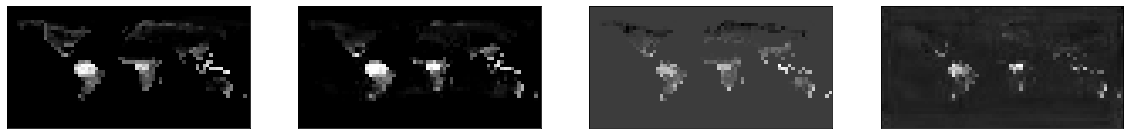


[22] - Finished evaluation - val_loss: 0.2468

[EPOCH] ____________________23____________________
[23] - Finished Epoch in 38.84 seconds - train_loss: 0.0935


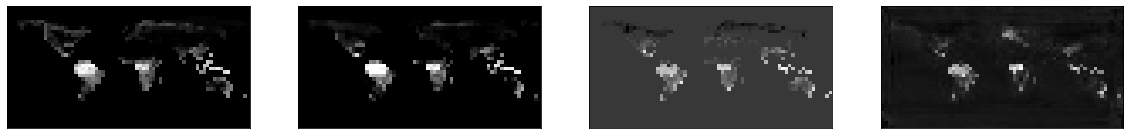


[23] - Finished evaluation - val_loss: 0.1841

[EPOCH] ____________________24____________________
[24] - Finished Epoch in 37.76 seconds - train_loss: 0.0908


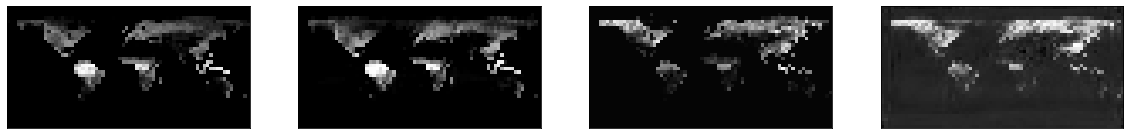


[24] - Finished evaluation - val_loss: 0.1680

[INFO] - Total time elapsed: 5.2452 min. Total time remaining: 15.7356 min.

[EPOCH] ____________________25____________________
[25] - Finished Epoch in 37.61 seconds - train_loss: 0.0926


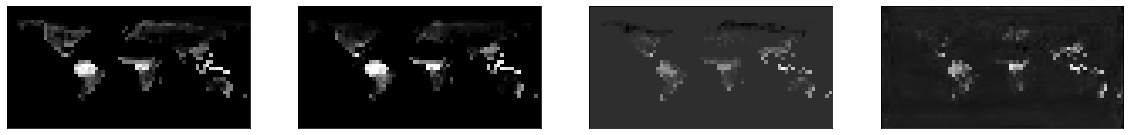


[25] - Finished evaluation - val_loss: 0.1622

[EPOCH] ____________________26____________________
[26] - Finished Epoch in 37.36 seconds - train_loss: 0.0845


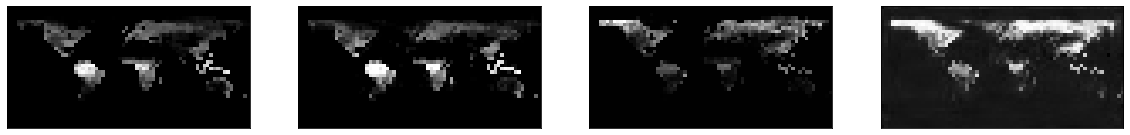


[26] - Finished evaluation - val_loss: 0.1240

[EPOCH] ____________________27____________________
[27] - Finished Epoch in 37.67 seconds - train_loss: 0.0831


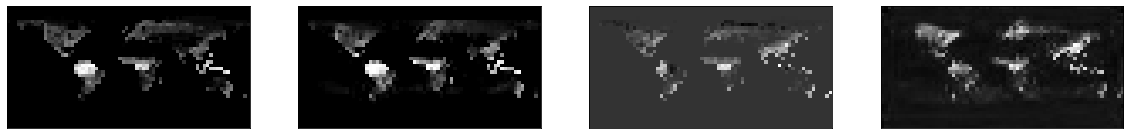


[27] - Finished evaluation - val_loss: 0.1566

[INFO] - Total time elapsed: 5.8590 min. Total time remaining: 15.0659 min.

[EPOCH] ____________________28____________________
[28] - Finished Epoch in 37.37 seconds - train_loss: 0.0784


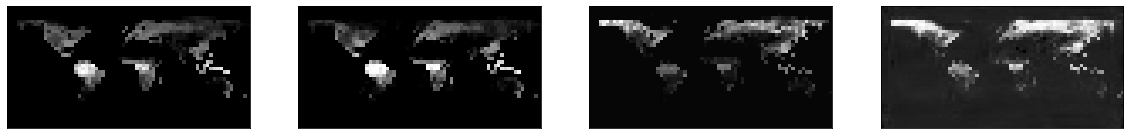


[28] - Finished evaluation - val_loss: 0.1452

[EPOCH] ____________________29____________________
[29] - Finished Epoch in 37.45 seconds - train_loss: 0.0768


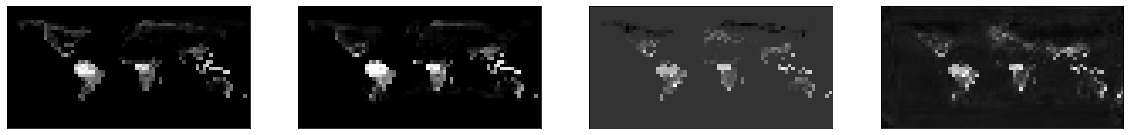


[29] - Finished evaluation - val_loss: 0.1326

[EPOCH] ____________________30____________________
[30] - Finished Epoch in 37.56 seconds - train_loss: 0.0770


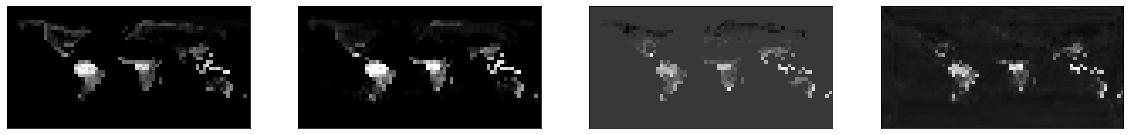


[30] - Finished evaluation - val_loss: 0.1350

[INFO] - Total time elapsed: 6.4743 min. Total time remaining: 14.4106 min.

[EPOCH] ____________________31____________________
[31] - Finished Epoch in 37.44 seconds - train_loss: 0.0734


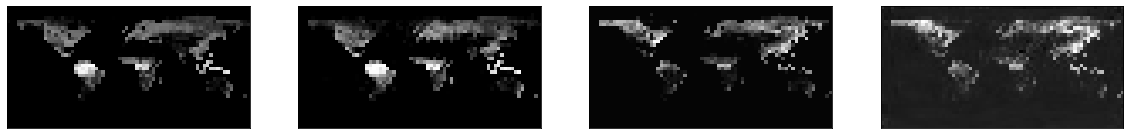


[31] - Finished evaluation - val_loss: 0.1223

[EPOCH] ____________________32____________________
[32] - Finished Epoch in 37.38 seconds - train_loss: 0.0697


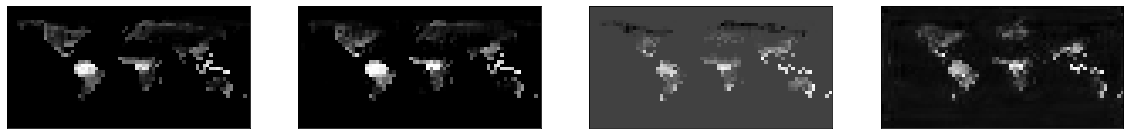


[32] - Finished evaluation - val_loss: 0.1273

[EPOCH] ____________________33____________________
[33] - Finished Epoch in 38.41 seconds - train_loss: 0.0742


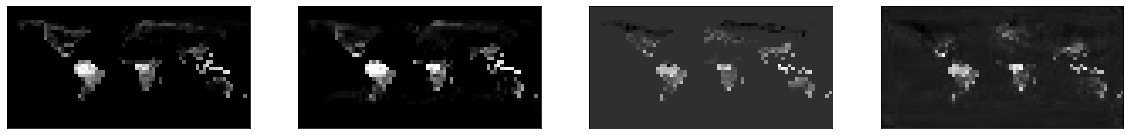


[33] - Finished evaluation - val_loss: 0.1259

[INFO] - Total time elapsed: 7.0998 min. Total time remaining: 13.7819 min.

[EPOCH] ____________________34____________________
[34] - Finished Epoch in 39.92 seconds - train_loss: 0.0683


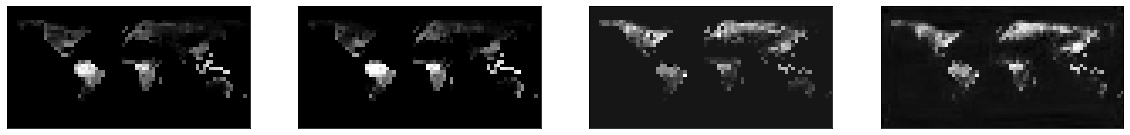


[34] - Finished evaluation - val_loss: 0.1128

[EPOCH] ____________________35____________________
[35] - Finished Epoch in 38.56 seconds - train_loss: 0.0694


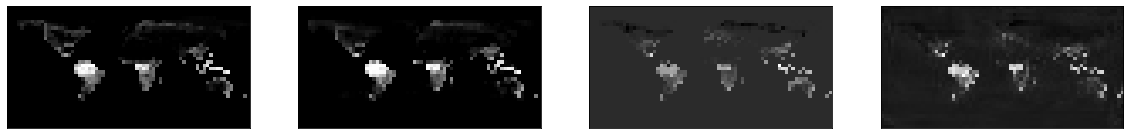


[35] - Finished evaluation - val_loss: 0.0994

[EPOCH] ____________________36____________________
[36] - Finished Epoch in 38.08 seconds - train_loss: 0.0648


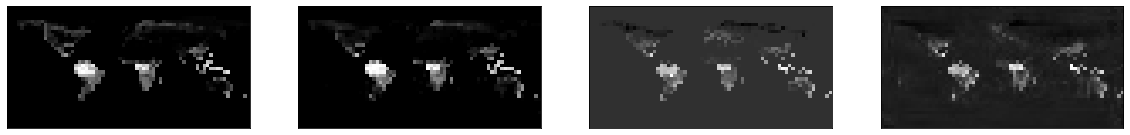


[36] - Finished evaluation - val_loss: 0.1279

[INFO] - Total time elapsed: 7.7284 min. Total time remaining: 13.1592 min.

[EPOCH] ____________________37____________________
[37] - Finished Epoch in 38.69 seconds - train_loss: 0.0625


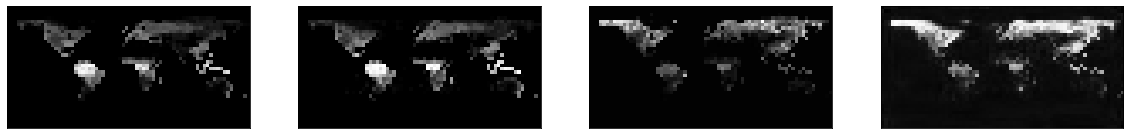


[37] - Finished evaluation - val_loss: 0.1061

[EPOCH] ____________________38____________________
[38] - Finished Epoch in 38.45 seconds - train_loss: 0.0623


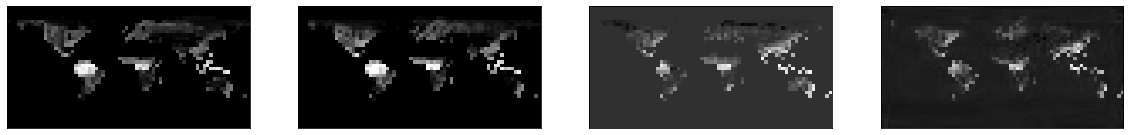


[38] - Finished evaluation - val_loss: 0.1011

[EPOCH] ____________________39____________________
[39] - Finished Epoch in 38.56 seconds - train_loss: 0.0612


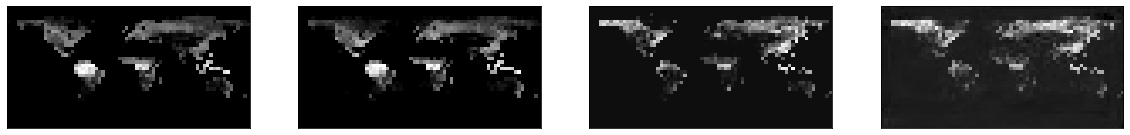


[39] - Finished evaluation - val_loss: 0.1015

[INFO] - Total time elapsed: 8.3562 min. Total time remaining: 12.5343 min.

[EPOCH] ____________________40____________________
[40] - Finished Epoch in 38.04 seconds - train_loss: 0.0617


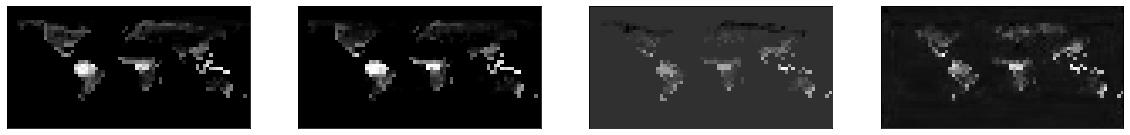


[40] - Finished evaluation - val_loss: 0.1071

[EPOCH] ____________________41____________________
[41] - Finished Epoch in 37.99 seconds - train_loss: 0.0585


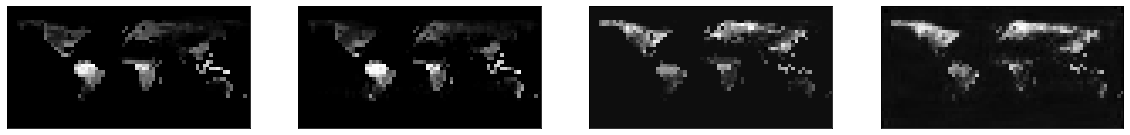


[41] - Finished evaluation - val_loss: 0.1244

[EPOCH] ____________________42____________________
[42] - Finished Epoch in 37.89 seconds - train_loss: 0.0596


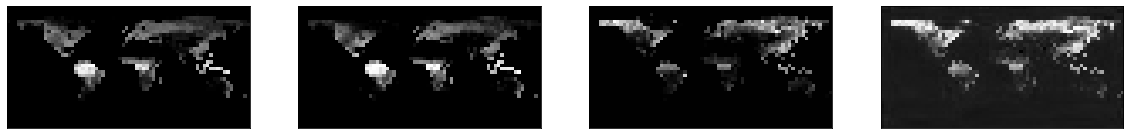


[42] - Finished evaluation - val_loss: 0.1028

[INFO] - Total time elapsed: 8.9755 min. Total time remaining: 11.8978 min.

[EPOCH] ____________________43____________________
[43] - Finished Epoch in 37.47 seconds - train_loss: 0.0581


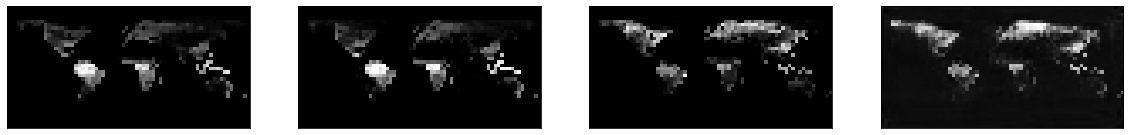


[43] - Finished evaluation - val_loss: 0.0997

[EPOCH] ____________________44____________________
[44] - Finished Epoch in 37.85 seconds - train_loss: 0.0600


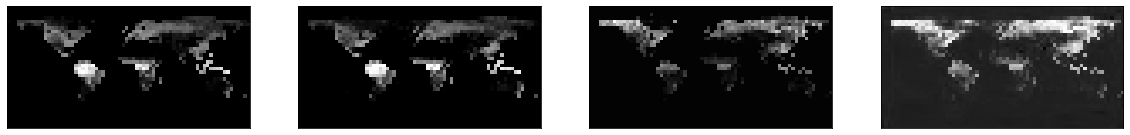


[44] - Finished evaluation - val_loss: 0.0995

[EPOCH] ____________________45____________________
[45] - Finished Epoch in 37.86 seconds - train_loss: 0.0584


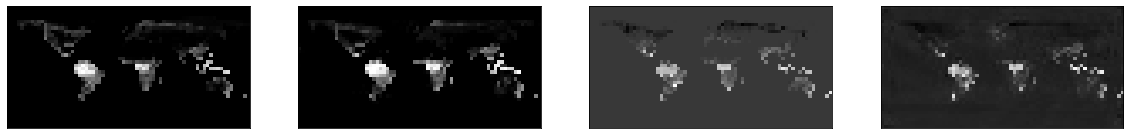


[45] - Finished evaluation - val_loss: 0.1130

[INFO] - Total time elapsed: 9.5928 min. Total time remaining: 11.2611 min.

[EPOCH] ____________________46____________________
[46] - Finished Epoch in 38.28 seconds - train_loss: 0.0570


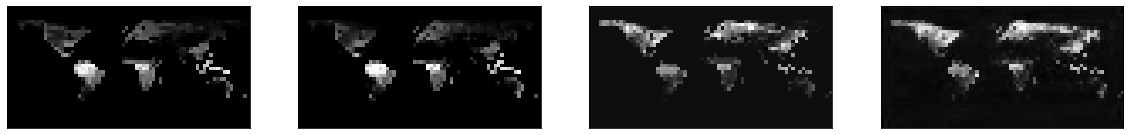


[46] - Finished evaluation - val_loss: 0.1016

[EPOCH] ____________________47____________________
[47] - Finished Epoch in 37.53 seconds - train_loss: 0.0530


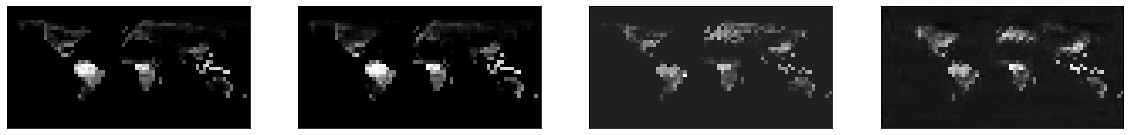


[47] - Finished evaluation - val_loss: 0.0897

[EPOCH] ____________________48____________________


In [ ]:
tf.keras.backend.clear_session()

for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()
    train_step(model, train_ds, loss_function, optimizer, train_loss_metric)
    train_loss = train_loss_metric.result()
    with train_summary_writer.as_default():     # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', train_loss, step=epoch)
    elapsed_time = timer.stop()
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}')
    
    # evaluation step with metrics update--------------------------------------------------------
    timer.start()
    eval_step(model, val_ds, loss_function, loss_metric=val_loss_metric)
    plt.show()
    val_loss = val_loss_metric.result()    
    with val_summary_writer.as_default():       # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', val_loss, step=epoch)    
    print(f'\n[{epoch}] - Finished evaluation - val_loss: {val_loss:0.4f}')#, val_accuracy: {val_acc:0.4f}')
    
    # Resetting train and validation metrics-----------------------------------------------------
    train_loss_metric.reset_states()
    val_loss_metric.reset_states()
    elapsed_time = timer.stop()
    times.append(elapsed_time)
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

In [76]:
training_name = "Version1"

model.save_weights("model_weights/"+ training_name + ".hdf5",save_format="hdf5",overwrite=False)

In [79]:
def load_weights(Model, weight_file, dataset, input_shape):
    """
    Builds the model by using the call method on input and then loads the weights.
    """
    for sequence, t in dataset.take(1):
        model2(sequence, training=False, input_shape=input_shape)
        
    return Model.load_weights()

In [80]:
weight_file = "model_weights/Version1.hdf5"
model2 = ConvLSTM(num_filters=num_filters)